# [  ]

In [1]:
import fatbot as fb
import torch.nn as nn
import numpy as np
import fatbot.db4 as db
import matplotlib.pyplot as plt
import os

# Setup

### RL Algorithm

In [2]:
sbalgo =                fb.PPO         #<----- model args depend on this
model_name =            'ppo_model'    #<----- stores data in this folder
os.makedirs(model_name, exist_ok=True)

### Reward Scheme

In [3]:
reward_scheme = dict( 
                #dis_target_point=   1.0, 
                dis_neighbour = 1.0,
                #dis_target_radius=  1.0, 
                all_unsafe=         1.0, 
                all_neighbour=      1.0, 
                occluded_neighbour= 2.0, 
                )
delta_reward = True

### Hyperparams

In [4]:
gamma =                 0.90
horizon =               300
total_timesteps =       100_000 #<--- for training
model_version =         'base'
model_path =            os.path.join(model_name, model_version)

# learning rate scheduling
start_lr, end_lr = 0.00050, 0.000040
lr_mapper=fb.REMAP((-0.2,1), (start_lr, end_lr)) # set learn rate schedluer
def lr_schedule(progress):
  #progress_precent = 100*(1-progress)
  #lr = lr_mapper.in2map(1-progress)
  #if int(progress_precent) % 10 == 0:
  #  print(f'Progress: {progress} ~~> {progress_precent:.3f} %,  {lr = }')  
  return lr_mapper.in2map(1-progress) #lr

# Training

### prepare

In [5]:
# initial state distribution - uniformly sample from all listed states
initial_state_keys =  db.all_states() # [db.isd[db.isd_keys[0]]] #[v for k,v in db.isd.items()] 
permute_states =        False
print(f'Total Initial States: {len(initial_state_keys)}')

# build training env
training_env = db.envF(False, horizon, reward_scheme, delta_reward, 
                        permute_states, *initial_state_keys)

#<---- optinally check
fb.check_env(training_env) 

Total Initial States: 11
[*] World Created :: world_db4 :: Dim: ( X=40.0, Y=40.0, H=300 )
Delta-Reward: [True],  Delta-Action: [False]
Imaging: [False],  History: [False]



c:\Program Files\Python38\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


### perform training

In [6]:
# start training
training_start_time = fb.common.now()
print(f'Training @ [{model_path}]')
model = sbalgo(policy=      'MlpPolicy', 
        env=                training_env, 
        learning_rate =     lr_schedule,
        n_steps=            2048+1024,
        batch_size =        64+32,
        n_epochs =          20,
        gamma =             gamma,
        gae_lambda=         0.95,
        clip_range=         0.25, 
        clip_range_vf=      None, 
        normalize_advantage=True, 
        ent_coef=           0.0, 
        vf_coef=            0.5, 
        max_grad_norm=      0.5, 
        use_sde=            False, 
        sde_sample_freq=    -1, 
        target_kl=          None, 
        tensorboard_log=    None, 
        create_eval_env=    False, 
        verbose=            0, 
        seed=               None, 
        device=             'cpu', 
        _init_setup_model=  True,
        policy_kwargs=dict(
                        activation_fn=  nn.LeakyReLU, 
                        net_arch=[dict(
                            pi=[400, 300, 300, 300], 
                            vf=[400, 300, 300, 300])])) #256, 256, 256, 128, 128

model.learn(total_timesteps=total_timesteps,log_interval=int(0.1*total_timesteps))
model.save(model_path)
training_end_time = fb.common.now()
print(f'Finished!, Time-Elapsed:[{training_end_time-training_start_time}]')

Training @ [ppo_model\base]
Finished!, Time-Elapsed:[0:07:49.680927]


# Testing

In [7]:
model = sbalgo.load(model_path)
model, model_path

(<stable_baselines3.ppo.ppo.PPO at 0x22ab485ddf0>, 'ppo_model\\base')

### prepare

In [8]:
# initial state distribution - uniformly sample from all listed states
initial_state_keys =    db.all_states() # [db.isd[db.isd_keys[0]]]  #[v for k,v in db.isd.items()] 
permute_states =        False
nos_initial_states=len(initial_state_keys)
print(f'Total Initial States: {nos_initial_states}')

horizon =               100
# build testing_env
testing_env = db.envF(True, horizon, reward_scheme, delta_reward, 
                        permute_states, *initial_state_keys)

# save initial state
#testing_env.reset()
#testing_env.save_state(f'{model_path}_initial.npy')
#fig=testing_env.render() # do a default render
#fig.savefig(f'{model_path}_initial.png')
#del fig

#<---- optinally check
#fb.check_env(training_env) 

Total Initial States: 11
[*] World Created :: world_db4 :: Dim: ( X=40.0, Y=40.0, H=100 )
Delta-Reward: [True],  Delta-Action: [False]
Imaging: [False],  History: [True]



### perform testing

Testing @ [ppo_model\base]
[.] Testing for [11] episodes @ [inf] steps

[++] Begin Epoch: Running for 11 episodes

[+] Begin Episode: 1 of 11
  [1/False]: Reward: 0.0013799667358398438
  [2/False]: Reward: 0.0044155120849609375
  [3/False]: Reward: 0.005957603454589844
  [4/False]: Reward: 0.3897242546081543
  [5/False]: Reward: 0.014074325561523438
  [6/False]: Reward: 0.014464378356933594
  [7/False]: Reward: 0.014826774597167969
  [8/False]: Reward: 0.015435218811035156
  [9/False]: Reward: 0.016402721405029297
  [10/False]: Reward: 0.016585826873779297
  [11/False]: Reward: 0.01617717742919922
  [12/False]: Reward: 0.4052276611328125
  [13/False]: Reward: 0.02012157440185547
  [14/False]: Reward: 0.018861770629882812
  [15/False]: Reward: 0.01732349395751953
  [16/False]: Reward: 0.01579427719116211
  [17/False]: Reward: 0.014269351959228516
  [18/False]: Reward: 0.012475013732910156
  [19/False]: Reward: 0.011049270629882812
  [20/False]: Reward: 0.010111808776855469
  [21/False]:

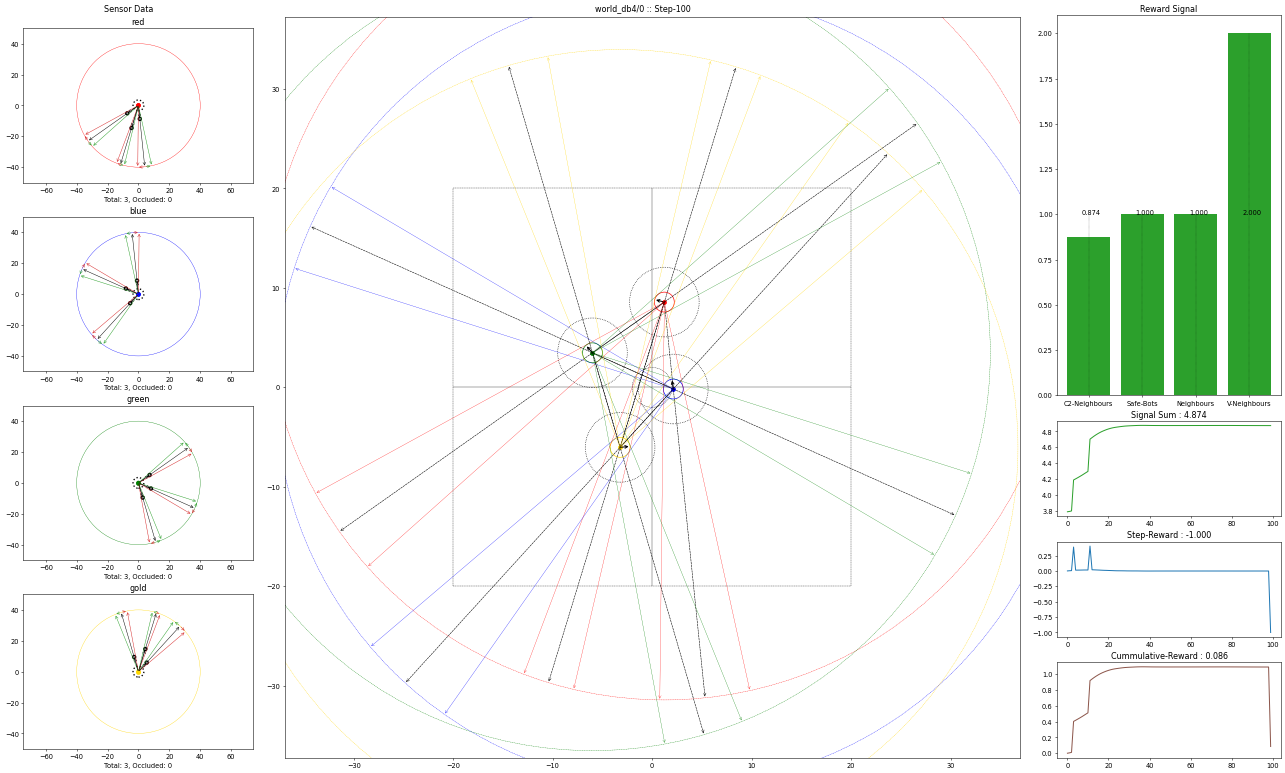

[x] End Episode: 1] :: Return: 0.0857696533203125, Steps: 100

[+] Begin Episode: 2 of 11
  [1/False]: Reward: 0.009716510772705078
  [2/False]: Reward: 0.011091232299804688
  [3/False]: Reward: 0.012321949005126953
  [4/False]: Reward: 0.011998176574707031
  [5/False]: Reward: 0.013057708740234375
  [6/False]: Reward: 0.014414787292480469
  [7/False]: Reward: 0.015084266662597656
  [8/False]: Reward: 0.016011714935302734
  [9/False]: Reward: 0.015635013580322266
  [10/False]: Reward: 0.013915538787841797
  [11/False]: Reward: 0.01384115219116211
  [12/False]: Reward: 0.014185905456542969
  [13/False]: Reward: 0.01323699951171875
  [14/False]: Reward: 0.008751869201660156
  [15/False]: Reward: 0.006634712219238281
  [16/False]: Reward: 0.004511833190917969
  [17/False]: Reward: 0.0026254653930664062
  [18/False]: Reward: 0.002117156982421875
  [19/False]: Reward: 0.0017347335815429688
  [20/False]: Reward: 0.0011496543884277344
  [21/False]: Reward: 0.0005249977111816406
  [22/False]: 

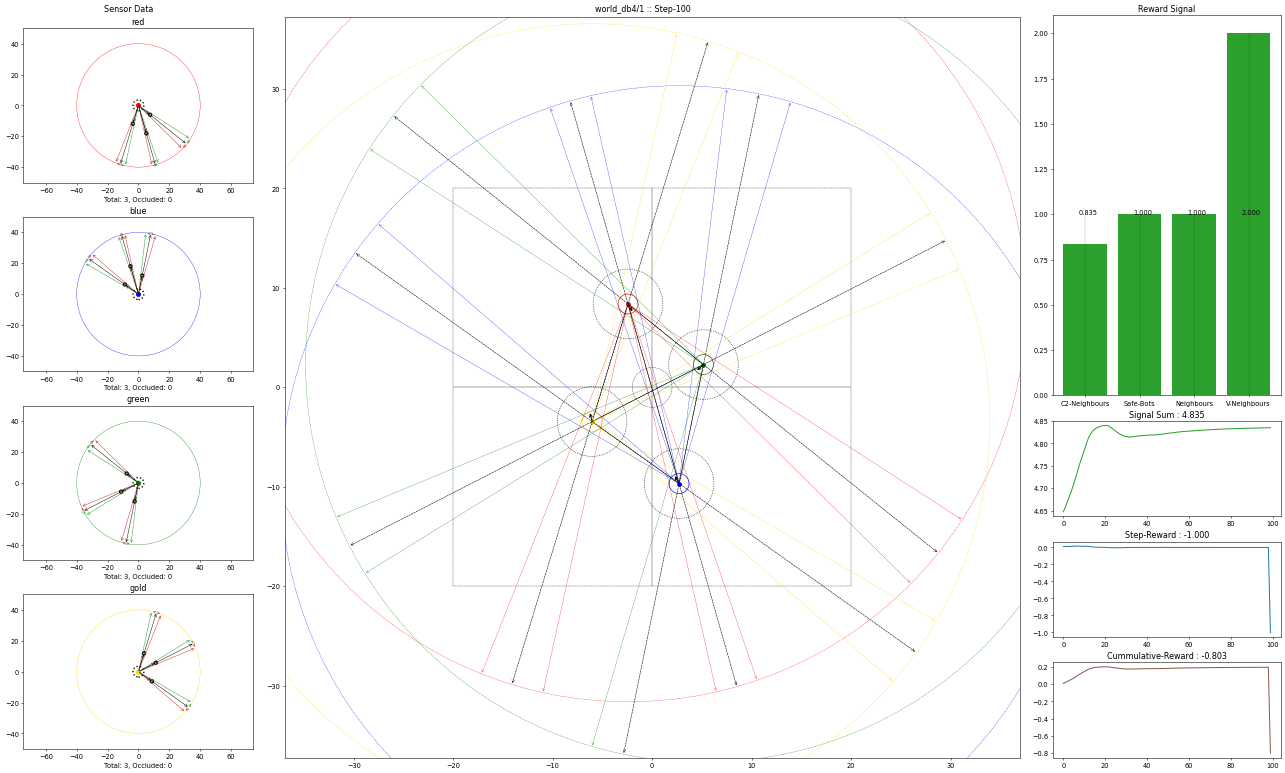

[x] End Episode: 2] :: Return: -0.8027482032775879, Steps: 100

[+] Begin Episode: 3 of 11
  [1/False]: Reward: 0.5157196521759033
  [2/False]: Reward: 0.511136531829834
  [3/False]: Reward: 0.010951042175292969
  [4/False]: Reward: 0.009029865264892578
  [5/False]: Reward: 0.007168292999267578
  [6/False]: Reward: 0.006726264953613281
  [7/False]: Reward: 0.006484508514404297
  [8/False]: Reward: 0.006697177886962891
  [9/False]: Reward: 0.006312847137451172
  [10/False]: Reward: 0.0052967071533203125
  [11/False]: Reward: 0.004855632781982422
  [12/False]: Reward: 0.004890918731689453
  [13/False]: Reward: 0.006577968597412109
  [14/False]: Reward: 0.006542682647705078
  [15/False]: Reward: 0.004968166351318359
  [16/False]: Reward: 0.004521369934082031
  [17/False]: Reward: 0.004170894622802734
  [18/False]: Reward: 0.004181861877441406
  [19/False]: Reward: 0.004099845886230469
  [20/False]: Reward: 0.0038504600524902344
  [21/False]: Reward: 0.0033779144287109375
  [22/False]: Rew

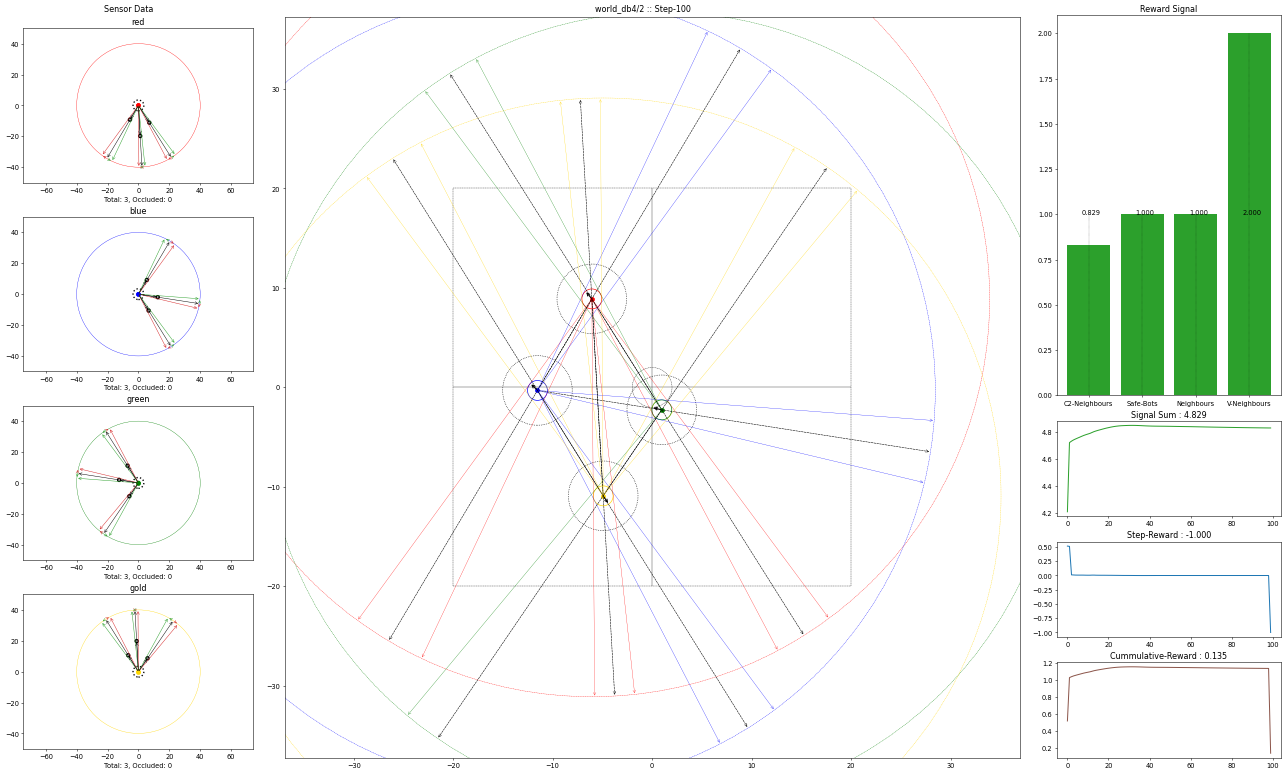

[x] End Episode: 3] :: Return: 0.1352217197418213, Steps: 100

[+] Begin Episode: 4 of 11
  [1/False]: Reward: 0.6823053359985352
  [2/False]: Reward: 0.1688375473022461
  [3/False]: Reward: -0.17015981674194336
  [4/False]: Reward: 0.00030231475830078125
  [5/False]: Reward: 0.16700220108032227
  [6/False]: Reward: 0.1650705337524414
  [7/False]: Reward: -0.0014715194702148438
  [8/False]: Reward: -0.0022559165954589844
  [9/False]: Reward: -0.0008769035339355469
  [10/False]: Reward: 0.0019683837890625
  [11/False]: Reward: 0.00311279296875
  [12/False]: Reward: 0.0043735504150390625
  [13/False]: Reward: 0.006796360015869141
  [14/False]: Reward: -0.1573033332824707
  [15/False]: Reward: 0.011855602264404297
  [16/False]: Reward: 0.17820405960083008
  [17/False]: Reward: -0.15940189361572266
  [18/False]: Reward: 0.17742443084716797
  [19/False]: Reward: 0.007546424865722656
  [20/False]: Reward: 0.00763702392578125
  [21/False]: Reward: 0.007079124450683594
  [22/False]: Reward: 0.

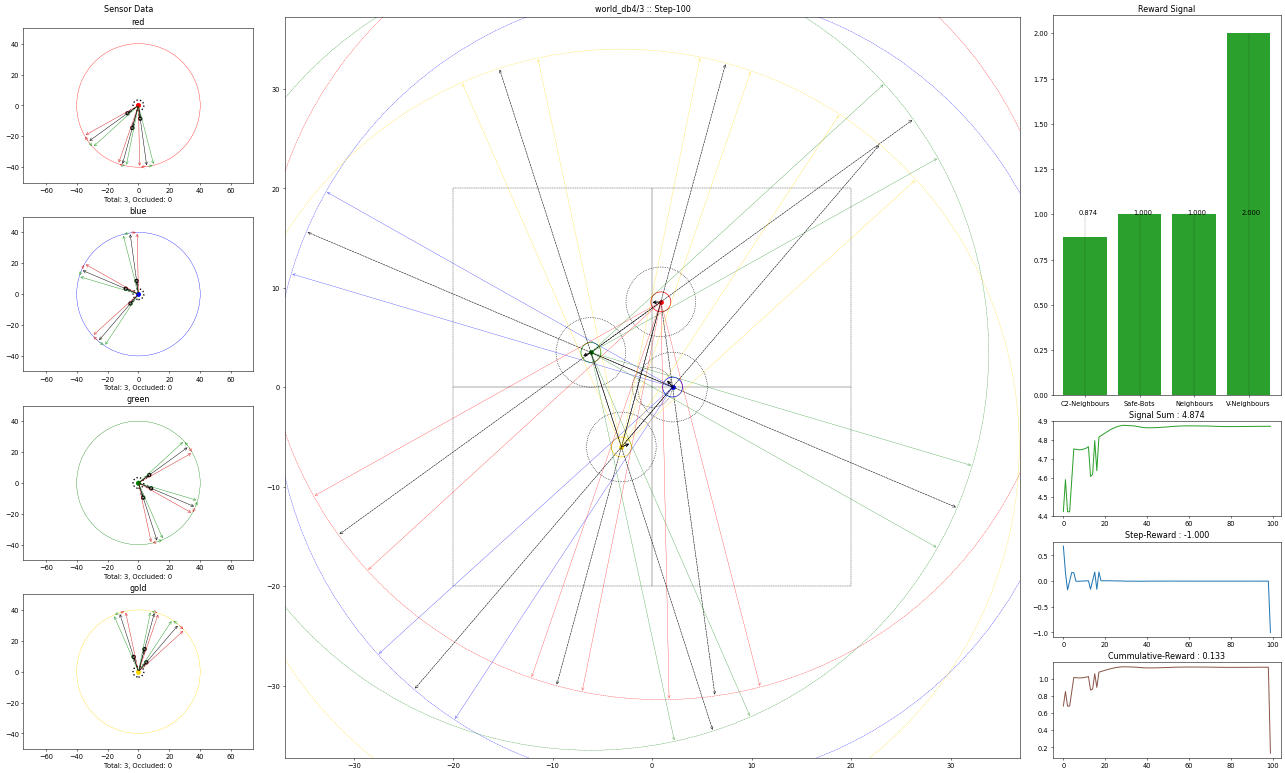

[x] End Episode: 4] :: Return: 0.1333932876586914, Steps: 100

[+] Begin Episode: 5 of 11
  [1/False]: Reward: 0.6763772964477539
  [2/False]: Reward: 0.005470752716064453
  [3/False]: Reward: 0.06083488464355469
  [4/False]: Reward: 0.34308671951293945
  [5/False]: Reward: 0.019882678985595703
  [6/False]: Reward: 0.019823074340820312
  [7/False]: Reward: 0.019699573516845703
  [8/False]: Reward: 0.019003868103027344
  [9/False]: Reward: 0.015866756439208984
  [10/False]: Reward: 0.012207984924316406
  [11/False]: Reward: 0.010257720947265625
  [12/False]: Reward: 0.009656429290771484
  [13/False]: Reward: 0.00884866714477539
  [14/False]: Reward: 0.00803375244140625
  [15/False]: Reward: 0.007334709167480469
  [16/False]: Reward: 0.006768226623535156
  [17/False]: Reward: 0.006262779235839844
  [18/False]: Reward: 0.005497932434082031
  [19/False]: Reward: 0.004481315612792969
  [20/False]: Reward: 0.0038089752197265625
  [21/False]: Reward: 0.0034389495849609375
  [22/False]: Reward

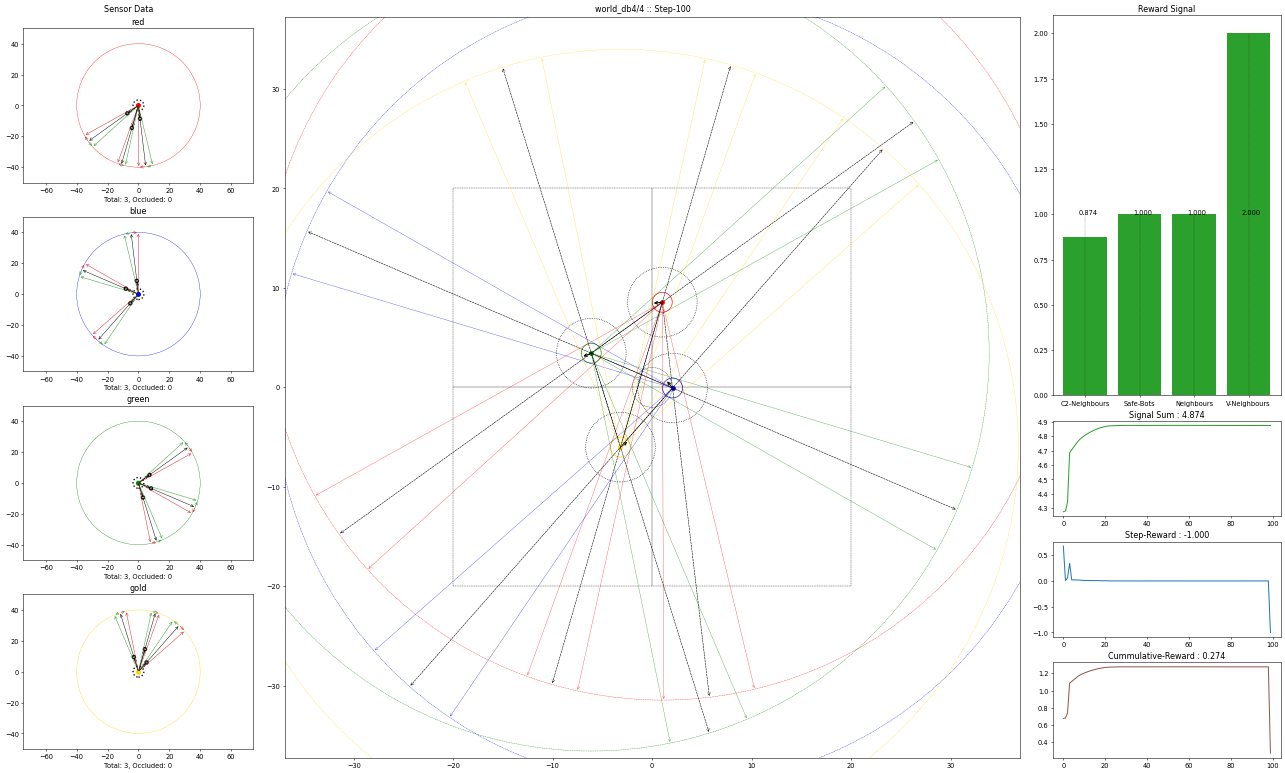

[x] End Episode: 5] :: Return: 0.27423715591430664, Steps: 100

[+] Begin Episode: 6 of 11
  [1/False]: Reward: 0.963860273361206
  [2/False]: Reward: 0.3907194137573242
  [3/False]: Reward: 0.39536094665527344
  [4/False]: Reward: 0.015166282653808594
  [5/False]: Reward: 0.01464700698852539
  [6/False]: Reward: 0.01409769058227539
  [7/False]: Reward: 0.013193130493164062
  [8/False]: Reward: 0.3963298797607422
  [9/False]: Reward: 0.01343536376953125
  [10/False]: Reward: 0.011232852935791016
  [11/False]: Reward: 0.009356021881103516
  [12/False]: Reward: 0.008953094482421875
  [13/False]: Reward: 0.008931159973144531
  [14/False]: Reward: 0.008489608764648438
  [15/False]: Reward: 0.008157730102539062
  [16/False]: Reward: 0.00816202163696289
  [17/False]: Reward: 0.008620262145996094
  [18/False]: Reward: 0.00952005386352539
  [19/False]: Reward: 0.010380744934082031
  [20/False]: Reward: 0.0111083984375
  [21/False]: Reward: 0.011859416961669922
  [22/False]: Reward: 0.011770725

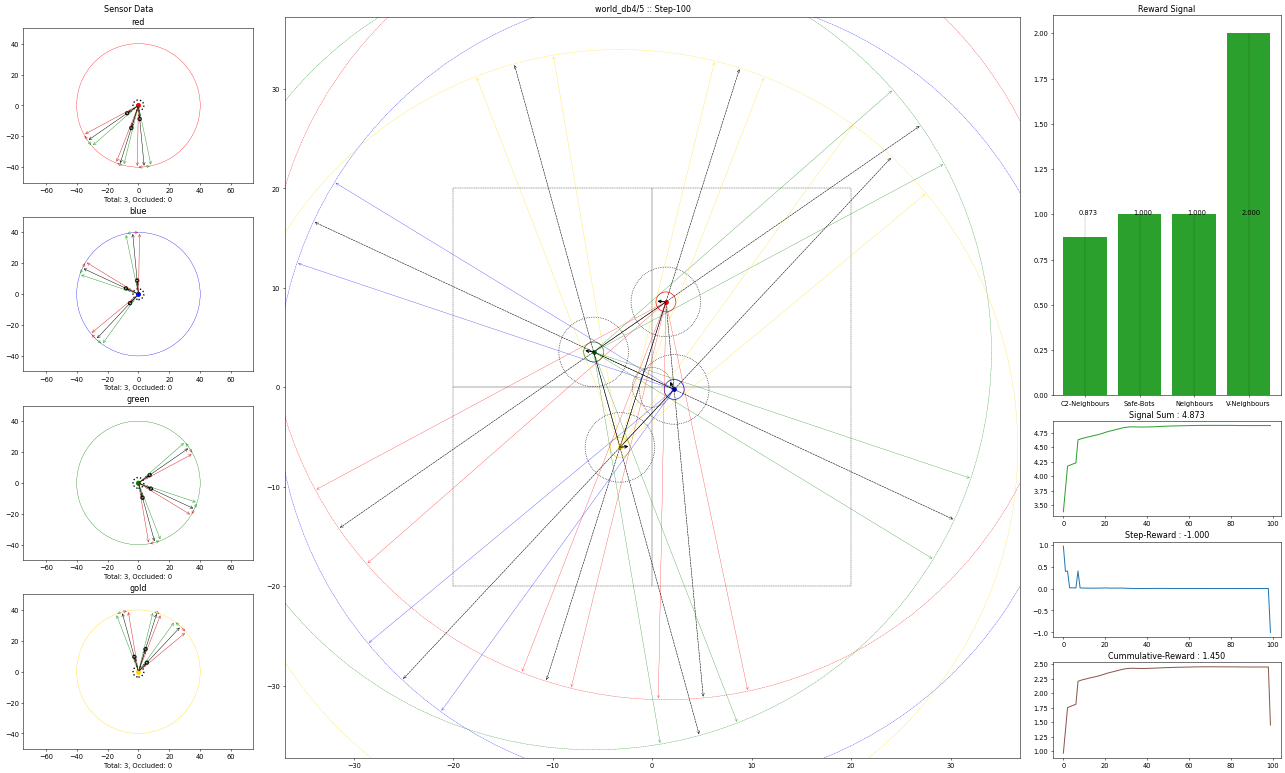

[x] End Episode: 6] :: Return: 1.4504001140594482, Steps: 100

[+] Begin Episode: 7 of 11
  [1/False]: Reward: 0.18989324569702148
  [2/False]: Reward: 0.16785383224487305
  [3/False]: Reward: 0.0719757080078125
  [4/False]: Reward: 0.07669544219970703
  [5/False]: Reward: -0.16779470443725586
  [6/False]: Reward: -0.36426210403442383
  [7/False]: Reward: -0.16411685943603516
  [8/False]: Reward: 0.21286964416503906
  [9/False]: Reward: 0.6524848937988281
  [10/False]: Reward: 0.012182235717773438
  [11/False]: Reward: -0.32221174240112305
  [12/False]: Reward: 0.007773876190185547
  [13/False]: Reward: 0.006514072418212891
  [14/False]: Reward: 0.005096912384033203
  [15/False]: Reward: 0.004302978515625
  [16/False]: Reward: 0.0033779144287109375
  [17/False]: Reward: 0.33622074127197266
  [18/False]: Reward: 0.0060443878173828125
  [19/False]: Reward: 0.005615234375
  [20/False]: Reward: 0.0051517486572265625
  [21/False]: Reward: 0.004625797271728516
  [22/False]: Reward: 0.0041055

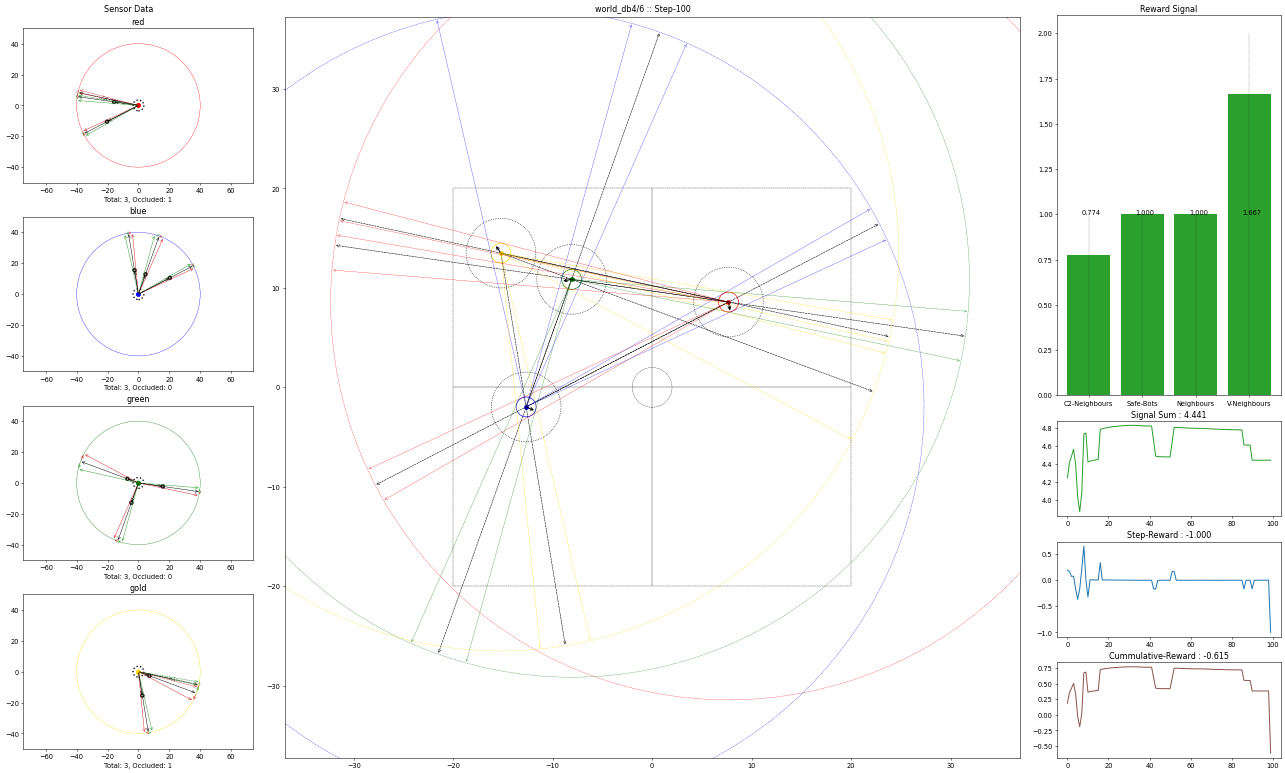

[x] End Episode: 7] :: Return: -0.6153707504272461, Steps: 100

[+] Begin Episode: 8 of 11
  [1/False]: Reward: 0.33781909942626953
  [2/False]: Reward: 0.005943775177001953
  [3/False]: Reward: 0.007270336151123047
  [4/False]: Reward: 0.008366584777832031
  [5/False]: Reward: 0.00829172134399414
  [6/False]: Reward: 0.006237983703613281
  [7/False]: Reward: 0.004660606384277344
  [8/False]: Reward: 0.003325939178466797
  [9/False]: Reward: 0.002201080322265625
  [10/False]: Reward: 0.0017719268798828125
  [11/False]: Reward: 0.0014414787292480469
  [12/False]: Reward: 0.0008788108825683594
  [13/False]: Reward: 0.0005731582641601562
  [14/False]: Reward: 0.0004172325134277344
  [15/False]: Reward: 0.0009899139404296875
  [16/False]: Reward: 0.0023317337036132812
  [17/False]: Reward: 0.0031256675720214844
  [18/False]: Reward: 0.0031337738037109375
  [19/False]: Reward: 0.004147529602050781
  [20/False]: Reward: 0.005095958709716797
  [21/False]: Reward: 0.0063114166259765625
  [22/F

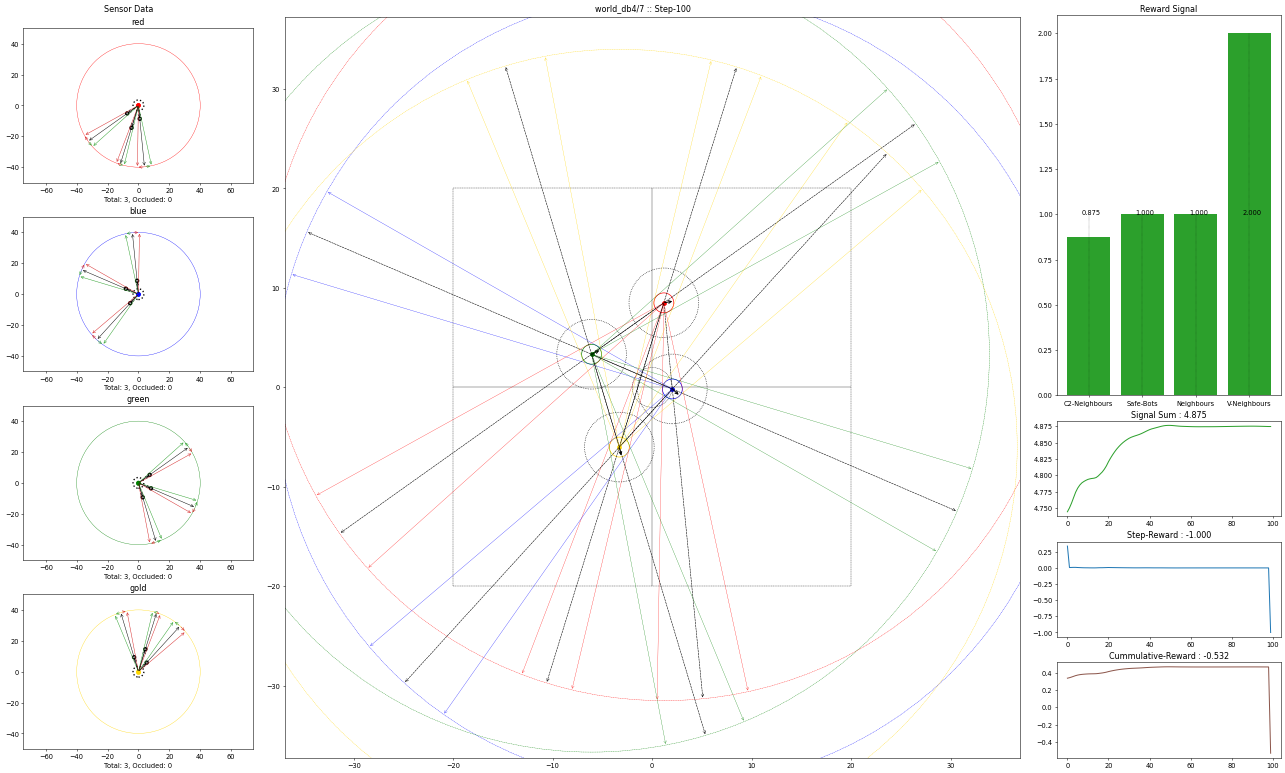

[x] End Episode: 8] :: Return: -0.5318493843078613, Steps: 100

[+] Begin Episode: 9 of 11
  [1/False]: Reward: 0.6550712585449219
  [2/False]: Reward: -0.005671024322509766
  [3/False]: Reward: -0.3373279571533203
  [4/False]: Reward: -0.0064563751220703125
  [5/False]: Reward: 0.3246798515319824
  [6/False]: Reward: -0.010261058807373047
  [7/False]: Reward: -0.011620521545410156
  [8/False]: Reward: -0.0093536376953125
  [9/False]: Reward: -0.008406639099121094
  [10/False]: Reward: -0.006290435791015625
  [11/False]: Reward: -0.00362396240234375
  [12/False]: Reward: -0.0018796920776367188
  [13/False]: Reward: 0.000293731689453125
  [14/False]: Reward: 0.0041255950927734375
  [15/False]: Reward: 0.004114627838134766
  [16/False]: Reward: 0.003016948699951172
  [17/False]: Reward: 0.0020418167114257812
  [18/False]: Reward: 0.0008273124694824219
  [19/False]: Reward: -0.0002570152282714844
  [20/False]: Reward: -0.0011014938354492188
  [21/False]: Reward: -0.0016608238220214844
  [

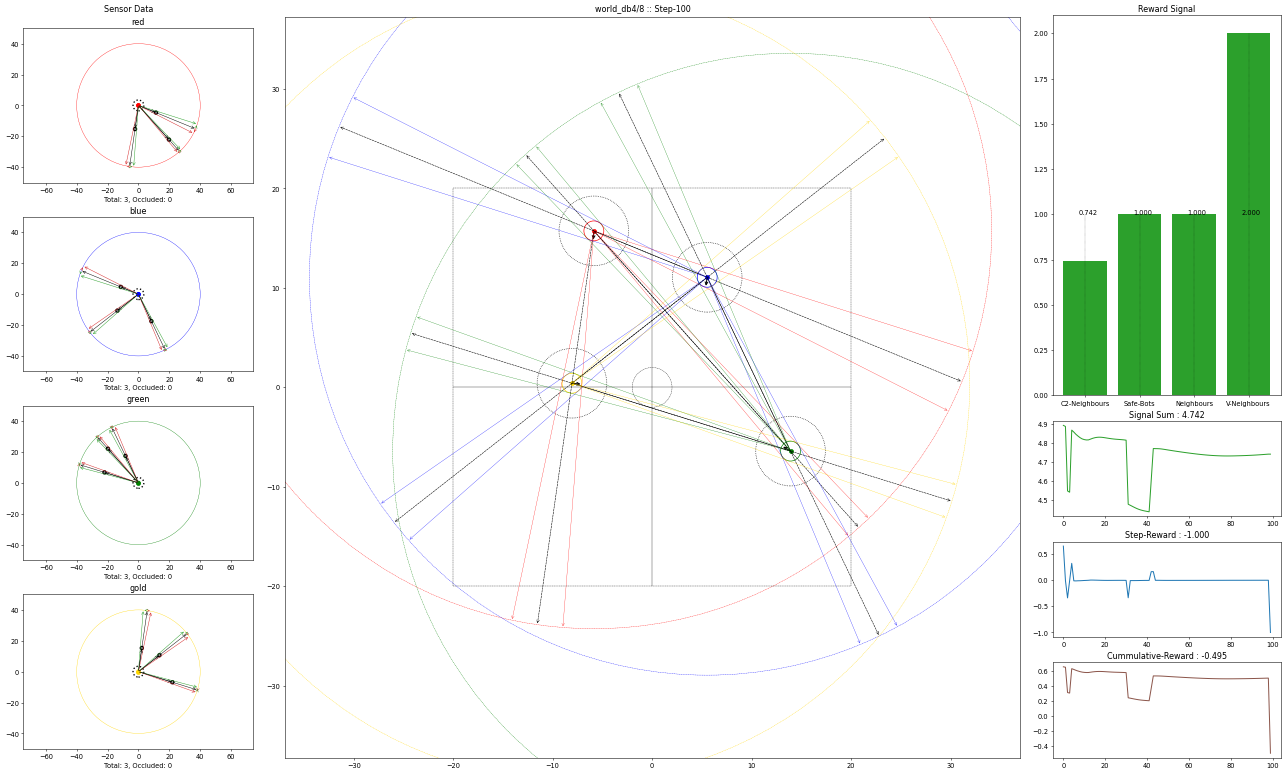

[x] End Episode: 9] :: Return: -0.4953160285949707, Steps: 100

[+] Begin Episode: 10 of 11
  [1/False]: Reward: -0.1598529815673828
  [2/False]: Reward: 0.33661413192749023
  [3/False]: Reward: -0.003342151641845703
  [4/False]: Reward: -0.005808830261230469
  [5/False]: Reward: -0.0023241043090820312
  [6/False]: Reward: 0.0024743080139160156
  [7/False]: Reward: 0.008440494537353516
  [8/False]: Reward: -0.32053041458129883
  [9/False]: Reward: 0.17895030975341797
  [10/False]: Reward: 0.17840194702148438
  [11/False]: Reward: 0.011827468872070312
  [12/False]: Reward: 0.009018898010253906
  [13/False]: Reward: 0.008410930633544922
  [14/False]: Reward: 0.007067680358886719
  [15/False]: Reward: 0.007383823394775391
  [16/False]: Reward: 0.007572174072265625
  [17/False]: Reward: 0.007049560546875
  [18/False]: Reward: 0.0064678192138671875
  [19/False]: Reward: 0.006326198577880859
  [20/False]: Reward: 0.006178855895996094
  [21/False]: Reward: 0.005581378936767578
  [22/False]: R

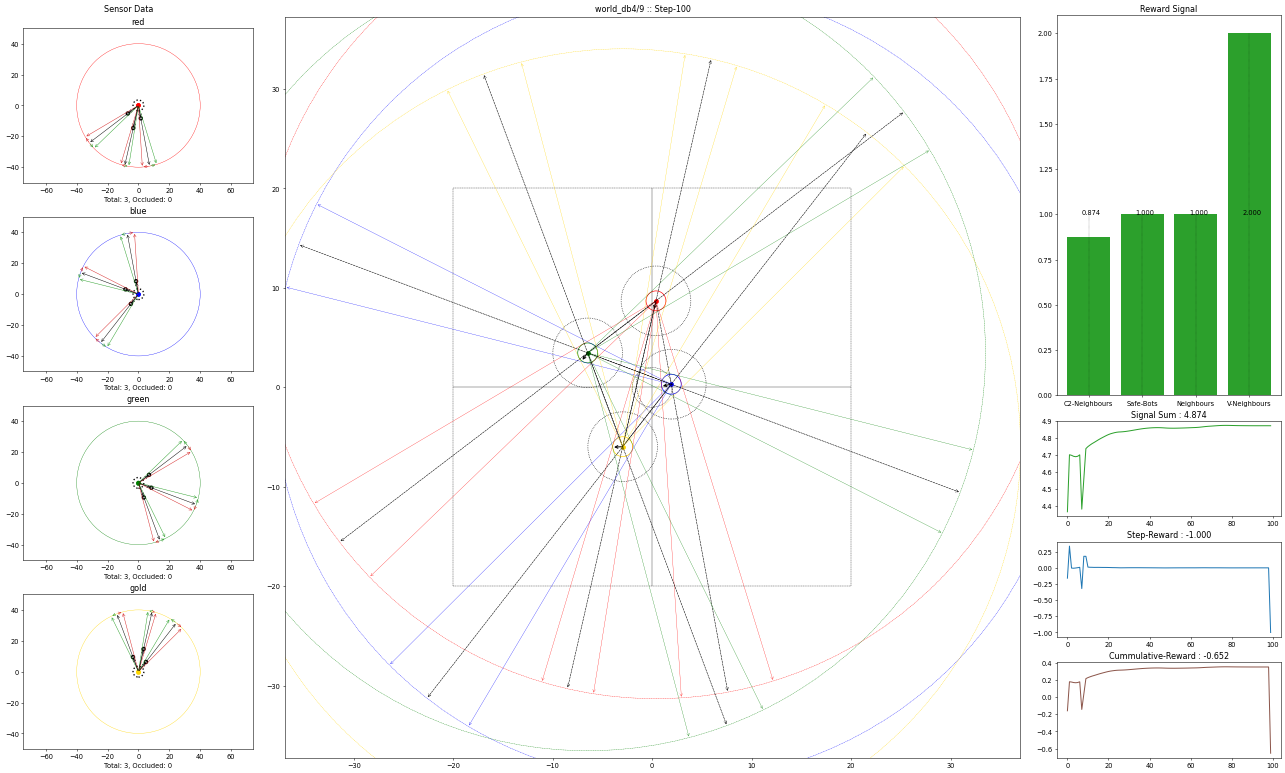

[x] End Episode: 10] :: Return: -0.6519851684570312, Steps: 100

[+] Begin Episode: 11 of 11
  [1/False]: Reward: 0.009387016296386719
  [2/False]: Reward: 0.003058910369873047
  [3/False]: Reward: 0.0013933181762695312
  [4/False]: Reward: 0.0010347366333007812
  [5/False]: Reward: 0.0008115768432617188
  [6/False]: Reward: 0.0019855499267578125
  [7/False]: Reward: 0.003337860107421875
  [8/False]: Reward: 0.004111766815185547
  [9/False]: Reward: 0.0036683082580566406
  [10/False]: Reward: 0.004008293151855469
  [11/False]: Reward: 0.0037140846252441406
  [12/False]: Reward: 0.002579212188720703
  [13/False]: Reward: 0.0010995864868164062
  [14/False]: Reward: 0.0003237724304199219
  [15/False]: Reward: -4.76837158203125e-06
  [16/False]: Reward: -0.00012254714965820312
  [17/False]: Reward: -0.0001068115234375
  [18/False]: Reward: -9.250640869140625e-05
  [19/False]: Reward: -8.726119995117188e-05
  [20/False]: Reward: -0.00014734268188476562
  [21/False]: Reward: -0.0002303123474

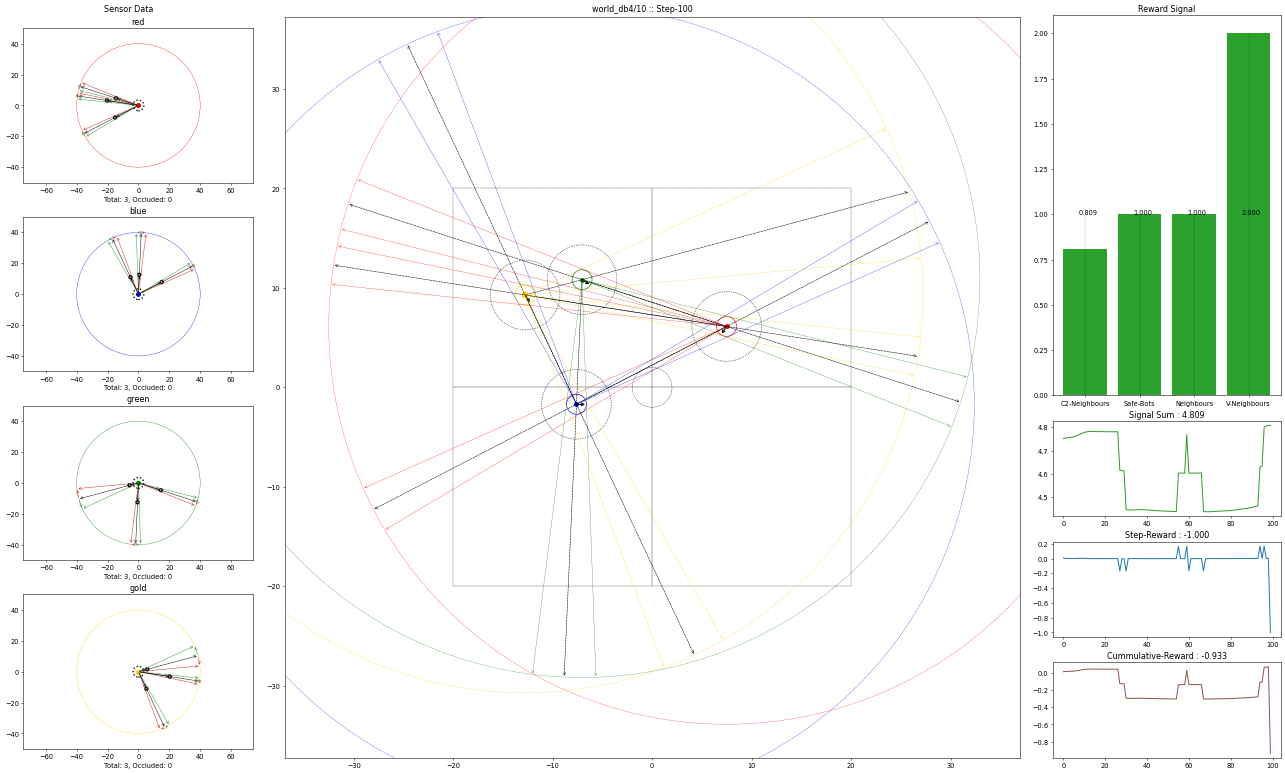

[x] End Episode: 11] :: Return: -0.9329752922058105, Steps: 100
[--] End Epoch [11] episodes :: Avg Return: -0.1773838996887207, Total Steps: 1100.0
average_return=-0.1773838996887207, total_steps=1100.0


In [9]:
print(f'Testing @ [{model_path}]')
average_return, total_steps = fb.TEST(
    env=            testing_env, 
    model=          sbalgo.load(model_path), #<---- use None for random
    episodes=       11,
    steps=          0,
    deterministic=  True,
    render_as=      'run_test', # use None for no plots, use '' (empty string) to plot inline
    save_dpi=       'figure',
    make_video=     False,
    video_fps=      2,
    render_kwargs=dict(local_sensors=True, reward_signal=True),
    starting_state=lambda ep: ep, # either none or lambda episode: initial_state_index (int)
    plot_results=0,
    start_n=0, # for naming render pngs
    save_state_info=model_path, # call plt.show() if true
    save_both_states=False,
)
print(f'{average_return=}, {total_steps=}')


